This example shows the simulation of a capacitor and an inductor.

To go further, you can read these pages on Wikipedia: [RC
circuit](https://en.wikipedia.org/wiki/RC_circuit) and [RL
circuit](https://en.wikipedia.org/wiki/RL_circuit).


In [1]:


import numpy as np
import matplotlib.pyplot as plt


import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()


from PySpice.Probe.Plot import plot
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

from scipy.optimize import curve_fit


# Warning: the capacitor/inductor return current in the generator
#  could use switches instead



We will use a simple circuit where both capacitor and inductor are
driven by a pulse source through a limiting current resistor.


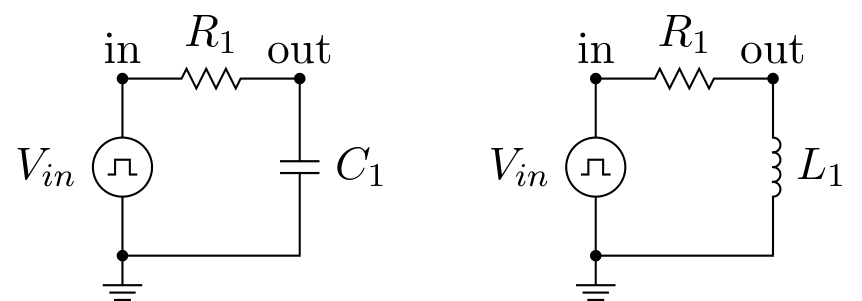

We will fit from the simulation output the time constant of each circuit
and compare it to the theoretical value.


2022-08-15 01:41:38,482 - PySpice.Spice.Netlist.Node - Netlist.WARNING - Node name 'in' is a Python keyword
tau capacitor = 1.0 ms
2022-08-15 01:41:38,785 - PySpice.Spice.Netlist.Node - Netlist.WARNING - Node name 'in' is a Python keyword
tau inductor = 1.0 ms


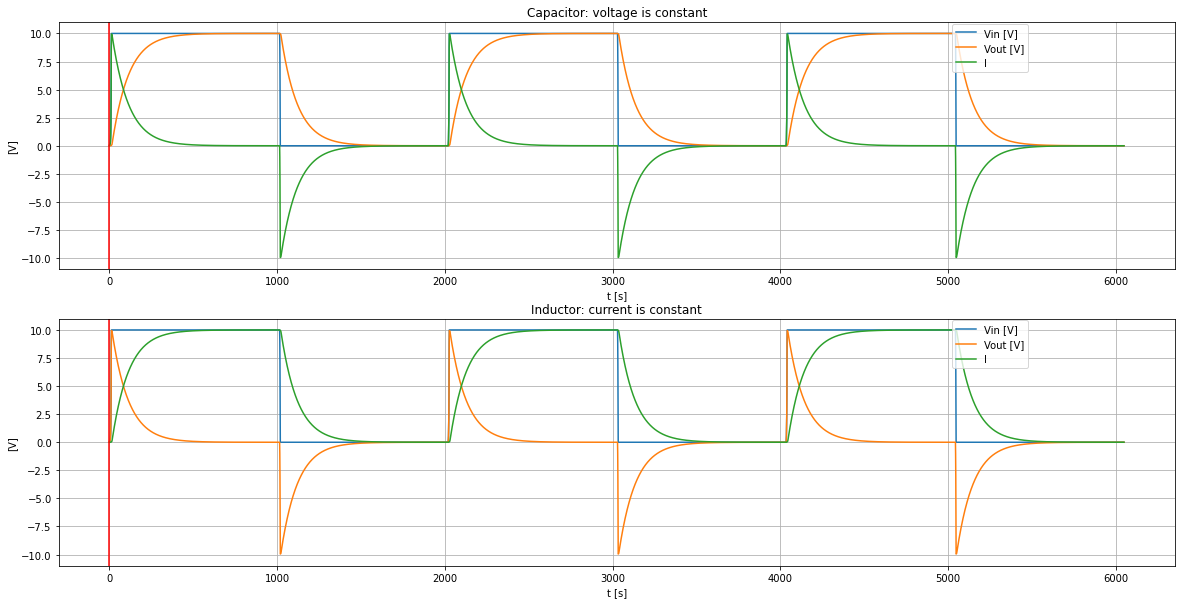

In [3]:

figure, (ax1, ax2) = plt.subplots(2, figsize=(20, 10))

element_types = ('capacitor', 'inductor')

for element_type in ('capacitor', 'inductor'):

    circuit = Circuit(element_type.title())
    source = circuit.PulseVoltageSource('input', 'in', circuit.gnd,
                           initial_value=0@u_V, pulsed_value=10@u_V,
                           pulse_width=10@u_ms, period=20@u_ms)
    circuit.R(1, 'in', 'out', 1@u_kΩ)
    if element_type == 'capacitor':
        element = circuit.C
        value = 1@u_uF
        # tau = RC = 1 ms
    else:
        element = circuit.L
        value = 1@u_H
        # tau = L/R = 1 ms
    element(1, 'out', circuit.gnd, value)
    # circuit.R(2, 'out', circuit.gnd, kilo(1)) 

    if element_type == 'capacitor':
        tau = circuit['R1'].resistance * circuit['C1'].capacitance
    else:
        tau = circuit['L1'].inductance / circuit['R1'].resistance

    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    step_time = 10@u_us
    analysis = simulator.transient(step_time=step_time, end_time=source.period*3)

    if element_type == 'capacitor':
        def out_voltage(t, tau):
            # Fixme: TypeError: only length-1 arrays can be converted to Python scalars
            return float(source.pulsed_value) * (1 -  np.exp(-t / tau))
    else:
        def out_voltage(t, tau):
            return float(source.pulsed_value) * np.exp(-t / tau)
    i_max = int(5 * tau / float(step_time))
    #popt, pcov = curve_fit(out_voltage, analysis.out.abscissa[:i_max], analysis.out[:i_max])
    #tau_measured = popt[0]

    print('tau {0} = {1}'.format(element_type, tau.canonise().str_space()))
    #print('tau measured {0} = {1:.1f} ms'.format(element_type, tau_measured * 1000))

    if element_type == 'capacitor':
        ax = ax1
        title = "Capacitor: voltage is constant"
    else:
        ax = ax2
        title = "Inductor: current is constant"
    ax.set_title(title)
    ax.grid()
    current_scale = 1000
    ax.plot(analysis['in'])
    ax.plot(analysis['out'])
    ax.plot(((analysis['in'] - analysis.out)/circuit['R1'].resistance) * current_scale)
    ax.axvline(x=float(tau), color='red')
    ax.set_ylim(-11, 11)
    ax.set_xlabel('t [s]')
    ax.set_ylabel('[V]')
    ax.legend(('Vin [V]', 'Vout [V]', 'I'), loc=(.8,.8))


In [4]:

plt.tight_layout()



<Figure size 432x288 with 0 Axes>